In [211]:
%load_ext autoreload
%autoreload 2

import os
import pathlib
import operator
import math
import json
import re
import datetime
import typing
import functools
import collections
import pickle

import numpy as np
import pandas as pd
import cv2
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate

import onnx
import onnxruntime
import torch
import torchvision

from torchvision.models import resnet50, mobilenetv3
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

from painting_estimation.images.utils import image_size, ImgSize
from painting_estimation.images.preprocessing import ImagePreprocessor
from painting_estimation.inference.inference import ONNXModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
MODEL_PATH = pathlib.Path.cwd().parent / "models"

In [3]:
MOBILENET_V3_PATH = MODEL_PATH / "mobilenet_v3_large_feature_extractor.onnx"

In [4]:
ONNX_OPSET_VERSION = 15
DEVICE = torch.device("cpu")


def to_numpy(tensor: torch.Tensor) -> np.ndarray:
    """Helper function to convert torch tensor to numpy."""
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()


def onnx_convert(
    model: torch.nn.Module,
    onnx_model_path: str,
    input_size: typing.Optional[ImgSize] = None,
    onnx_opset_version: int = ONNX_OPSET_VERSION,
) -> None:
    """Covert fitted PyTorch detection model to ONNX."""
    model.to(DEVICE)
    model.eval()

    input_dynamic_axes: dict[int, str] = {0: "batch_size"}
    output_dynamic_axes: dict[int, str] = {0: "batch_size"}
    if input_size is None:
        input_size = ImgSize(*np.random.randint(400, 1000, 2).tolist())
        input_dynamic_axes.update({2: "height", 3: "width"})

    # preprocess pipeline for `source_image`:
    # img = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB)
    # --optional (if static input size assumed)-- img = wv.rescale(img, new_size=input_size)
    # img = img.astype(np.float32) / 255.0
    # img = img.transpose(2, 0, 1).astype(np.float32)

    # only batch_size == 1 allowed
    dummy: torch.Tensor = torch.rand(1, 3, input_size.height, input_size.width)
    torch_out = model(dummy.detach())

    torch.onnx.export(
        model,  # model being run
        dummy,  # model input (or a tuple for multiple inputs)
        onnx_model_path,  # where to save the model (can be a file or file-like object)
        export_params=True,  # store the trained parameter weights inside the model file
        opset_version=onnx_opset_version,  # the ONNX version to export the model to
        do_constant_folding=True,  # whether to execute constant folding for optimization
        input_names=["input"],  # the model's input names
        output_names=["features"],  # the model's output names
        dynamic_axes={
            "input": input_dynamic_axes,
            "features": output_dynamic_axes,
        },
    )

    onnx_model = onnx.load(onnx_model_path)
    onnx.checker.check_model(onnx_model)

    ort_session = onnxruntime.InferenceSession(onnx_model_path)

    # compute ONNX Runtime output prediction
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(dummy)}
    ort_outs = ort_session.run(None, ort_inputs)
    # compare ONNX Runtime and PyTorch results
    np.testing.assert_allclose(np.array(torch_out["features"].detach()), np.array(ort_outs[0]), rtol=1e-03, atol=1e-05)

    print("Exported model has been tested with ONNXRuntime, and the result looks good!")

In [31]:
# m = resnet50(weights=torchvision.models.resnet.ResNet50_Weights.IMAGENET1K_V2)
m = mobilenetv3.mobilenet_v3_large(weights=torchvision.models.mobilenetv3.MobileNet_V3_Large_Weights.IMAGENET1K_V2)

train_nodes, eval_nodes = get_graph_node_names(m)

return_nodes = {
    'avgpool': 'features',
}

f_ext = create_feature_extractor(m, return_nodes=return_nodes)

In [33]:
onnx_convert(
    f_ext, 
    onnx_model_path=str(MOBILENET_V3_PATH), 
    input_size=ImgSize(width=224, height=224),
)

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Exported model has been tested with ONNXRuntime, and the result looks good!


In [5]:
MOBILE_NET_V3_PREPROCESSOR = ImagePreprocessor(
    target_size=ImgSize(width=224, height=224),
    target_dim_order=(2, 0 ,1),
    target_dtype=np.float32,
    interpolation=cv2.INTER_LINEAR,
    to_bgr=False,
    extra_batch_dim=0,
    normalize=True,
    means=(0.485, 0.456, 0.406),
    stds=(0.229, 0.224, 0.225),
    initial_size_before_crop=ImgSize(width=224, height=224),
)

In [6]:
EXTRACTOR = ONNXModel(MOBILENET_V3_PATH) 

In [7]:
DATA_PATH = pathlib.Path.cwd().parent / "data"

In [8]:
val_path = DATA_PATH / "val"
train_path = DATA_PATH / "from_Anton" / "artsynet"

In [9]:
val_anno = pd.read_csv(val_path / "artDataset.csv", index_col=0)
val_data = sorted((val_path / "artDataset").glob("*.png"), key=lambda x: int(x.stem.rsplit("_", 1)[1]))

In [10]:
target = val_anno.price.str.split(" ").transform(operator.itemgetter(0)).astype(float)
assert len(val_data) == len(target)

val_anno["target"] = target

In [11]:
np.log10(val_anno["target"]).mean()

1.2102699640450534

In [12]:
img = cv2.cvtColor(cv2.imread(str(val_data[0])), cv2.COLOR_BGR2RGB)

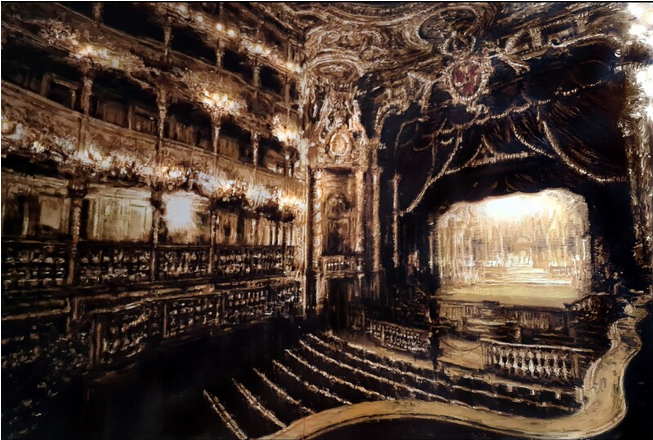

In [13]:
Image.fromarray(img)

In [14]:
AXIS = 0, 1
QUANTILES = [0.1, 0.25, 0.5, 0.75, 0.9]

def regular_features(img):
    img_size = image_size(img)
    
    features = []
    features.extend(img.mean(AXIS).tolist())
    features.extend(img.std(AXIS).tolist())
    features.extend(np.quantile(img, q=QUANTILES, axis=AXIS).ravel().tolist())
    
    return features

In [15]:
def extract_features_target(preprocessor, feature_extractor):
    X = []
    X_add = []
    for path, t in tqdm(zip(val_data, val_anno["target"]), total=len(val_data)):
        # RGB
        img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
        
        features = feature_extractor(preprocessor(img))
        X.append(features.ravel())
        X_add.append(regular_features(img))
        
    X = np.concatenate([np.asarray(X), np.asarray(X_add)], axis=1)
    y = val_anno["target"].values
    
    return X, y

In [16]:
X, y = extract_features_target(preprocessor=MOBILE_NET_V3_PREPROCESSOR, feature_extractor=EXTRACTOR)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 754/754 [00:49<00:00, 15.34it/s]


In [17]:
X.shape

(754, 981)

In [18]:
y.shape

(754,)

In [19]:
TEST_SIZE = 0.15
RANDOM_STATE = 4

y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True,
)

In [52]:
scaler = StandardScaler()
regr = Ridge(alpha=1000.0)

pipeline = Pipeline(steps=[("scaler", scaler), ("regr", regr)])

In [53]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('regr', Ridge(alpha=1000.0))])

In [57]:
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)


metrics = mean_squared_error(y_test, y_pred_log)

In [55]:
metrics

4.359261688442194

In [58]:
y_pred

array([ 11.20556286, 146.5946032 ,  27.5739692 ,   9.61805956,
         9.14579318,  36.72300723,  10.88977163,   5.39370103,
        85.9536536 ,   9.4911904 ,   1.80111305,  19.28079332,
        17.11840003,  21.55308917,  34.0961884 ,   9.00640125,
         4.8433175 ,  13.61581116,  15.66068356,  15.2967056 ,
        16.67474068,  61.00557626,  54.21750929,   6.16020749,
        11.04982733,  88.94845624,  72.86506597,  49.35973775,
        20.0455548 ,   7.93580733,  49.38380694,  50.10226576,
         2.92913414,  41.41173915,  15.5133857 ,  43.14278729,
        15.55263131,  51.19271998,  46.33056081, 136.98217895,
        21.46546801,  59.80529358,  18.62345256,  11.70872156,
        23.44977922,   5.31923978,  47.5964355 ,  15.29239064,
         9.9917281 ,   5.69153308,   2.9149448 ,  40.49000371,
        22.92309193,  31.32471575,  34.10640198,   4.33339438,
         5.16734144,  11.62732981,   2.00011563,   9.68872189,
        30.1036443 ,  14.66495262,  12.18317367,  23.50

In [61]:
np.expm1(y_test)

array([800.   , 800.   ,  12.   ,   2.5  ,  15.   ,   1.8  ,   4.   ,
         3.68 ,   3.   ,   1.275,  10.   ,  35.   , 680.   ,   7.   ,
         2.   ,   1.5  ,   1.275,   6.   ,   5.   ,   3.   ,  15.   ,
         1.275,   1.5  ,  12.   ,   2.25 ,   2.25 , 800.   , 680.   ,
         1.5  ,   8.   ,  54.   ,   6.   ,   4.   ,   3.   ,   6.   ,
       800.   ,   5.   ,  20.   ,   3.   , 800.   , 680.   , 800.   ,
        15.   ,  14.   ,  12.   ,   3.   ,   1.5  ,   6.   ,   7.5  ,
         6.   ,  22.5  ,  15.5  ,   1.895,   1.5  ,  21.   ,  32.   ,
        25.   ,   1.2  ,   8.5  ,   6.995, 800.   , 995.   ,   5.   ,
         2.   ,   1.5  ,   1.275,   9.5  , 800.   ,   3.   ,   8.   ,
       680.   ,   3.895,   9.   ,   2.5  ,   2.5  , 680.   ,   5.   ,
         5.   ,   1.5  ,   5.   , 680.   ,  48.   ,   1.5  ,  20.   ,
         1.5  , 800.   , 800.   ,   3.   ,  10.   , 800.   ,   4.   ,
       680.   ,   1.275, 800.   , 800.   ,   7.   ,  13.   ,   8.   ,
       800.   ,   3.

In [155]:
train_anno = pd.read_csv(train_path / "artsynet.csv", index_col=0)
train_data = sorted((train_path / "images").glob("*.jpg"), key=lambda x: int(x.stem.rsplit("-", 1)[1]))

In [66]:
img = cv2.cvtColor(cv2.imread(str(train_data[0])), cv2.COLOR_BGR2RGB)

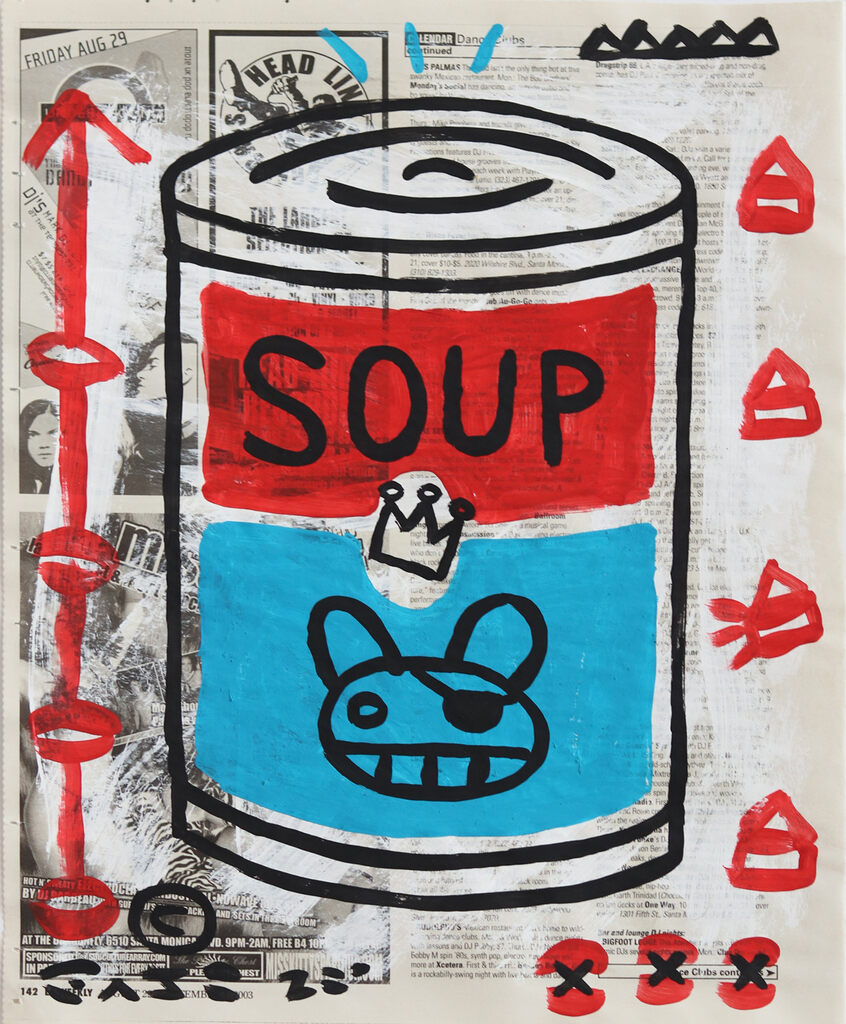

In [67]:
Image.fromarray(img)

In [157]:
range_mask = train_anno["sale_message"].str.find("–").ne(-1)

In [158]:
train_anno["price1"] = "min"
train_anno["price2"] = "max"
train_anno.loc[usd_mask, "p1"] = 0.0
train_anno.loc[usd_mask, "p2"] = 0.0

In [159]:
train_anno["price_range"] = train_anno["sale_message"].str.split("–")

In [160]:
train_anno.loc[range_mask, "price1"] = train_anno.loc[range_mask, "price_range"].transform(operator.itemgetter(0))
train_anno.loc[range_mask, "price2"] = train_anno.loc[range_mask, "price_range"].transform(operator.itemgetter(1))

In [161]:
train_anno.loc[~range_mask, "price2"] = train_anno.loc[~range_mask, "price_range"].transform(operator.itemgetter(0))

In [163]:
invalid_mask = train_anno["price2"].astype(bool)

for ccy, coef in zip(["US$", "€", "£"], [1.0, 1.1, 1.3]):
    ccy_mask = train_anno["price2"].str.startswith(ccy)
    invalid_mask &= ~ccy_mask
    train_anno.loc[ccy_mask, "p2"] = \
    train_anno.loc[ccy_mask, "price2"].str.strip(ccy).str.replace(",", "").replace(".", "").astype(float)
    ccy_range_mask = ccy_mask & range_mask
    train_anno.loc[ccy_range_mask, "p1"] = \
    train_anno.loc[ccy_range_mask, "price1"].str.strip(ccy).str.replace(",", "").replace(".", "").astype(float)
    
    train_anno.loc[ccy_range_mask, "p2"] += train_anno.loc[ccy_range_mask, "p1"]
    train_anno.loc[ccy_range_mask, "p2"] /= 2
    
    train_anno.loc[ccy_mask, "p2"] *= coef
    

<Axes: >

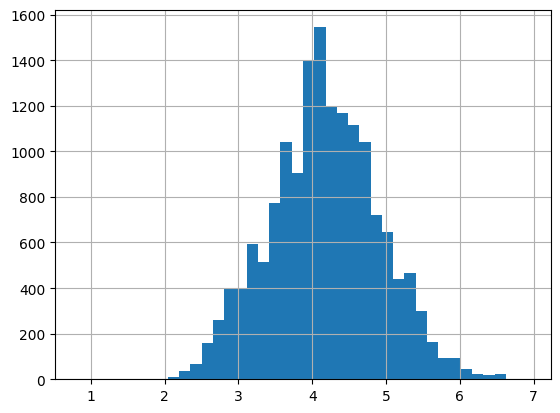

In [175]:
train_anno.loc[~invalid_mask, "p2"].transform(np.log10).hist(bins=40)

In [206]:
def extract_features_target(preprocessor, feature_extractor):
    X = []
    X_add = []
    y = []
    visited = set()
    
    for p, t, not_valid in tqdm(
        zip(train_anno["local_image"], train_anno["p2"], invalid_mask), total=len(train_anno)
    ):
        
        if not_valid or p in visited:
            continue
            
        path = train_path / "images" / p
        img = cv2.imread(str(path))
        if img is None:
            continue
        
        # RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        features = feature_extractor(preprocessor(img))
        X.append(features.ravel())
        X_add.append(regular_features(img))
        y.append(t)
        
        visited.add(p)
        
    X = np.concatenate([np.asarray(X), np.asarray(X_add)], axis=1)
    y = np.asarray(y)
    
    return X, y

In [207]:
X, y = extract_features_target(preprocessor=MOBILE_NET_V3_PREPROCESSOR, feature_extractor=EXTRACTOR)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 17788/17850 [11:28<00:05, 11.32it/s][ WARN:0@7278.393] global loadsave.cpp:244 findDecoder imread_('/Users/ruazvd5/PycharmProjects/raif-bootcamp-2023/data/from_Anton/artsynet/images/image-7644.jpg'): can't open/read file: check file path/integrity
[ WARN:0@7278.394] global loadsave.cpp:244 findDecoder imread_('/Users/ruazvd5/PycharmProjects/raif-bootcamp-2023/data/from_Anton/artsynet/images/image-7645.jpg'): can't open/read file: check file path/integrity
[ WARN:0@7278.394] global loadsave.cpp:244 findDecoder imread_('/Users/ruazvd5/PycharmProjects/raif-bootcamp-2023/data/from_Anton/artsynet/images/image-7646.jpg'): can't open/read file: check file path/integrity
[ WARN:0@7278.394] global loadsave.cpp:244 findDecoder imread_('/Users/ruazvd5/PycharmProjects/raif-bootcamp-2023/data/from_Anton/artsynet/images/image-7647.jpg'): can't open/read file: check file path/i

In [212]:
# x_path = train_path / "X.pkl"
# with open(str(x_path), "wb") as f:
#     pickle.dump(X, f)

In [213]:
# y_path = train_path / "y.pkl"
# with open(str(y_path), "wb") as f:
#     pickle.dump(y, f)

In [214]:
X.shape

(6906, 981)

In [215]:
y.shape

(6906,)

In [216]:
TEST_SIZE = 0.15
RANDOM_STATE = 4

y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True,
)

In [433]:
scaler = StandardScaler()
regr = Ridge(alpha=5.)

pipeline = Pipeline(steps=[("scaler", scaler), ("regr", regr)])

In [434]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('regr', Ridge(alpha=5.0))])

In [435]:
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)


metrics = mean_squared_error(y_test, y_pred_log, squared=False)

In [436]:
metrics / np.log(10) * np.log(np.e)

0.7268553858936618

In [241]:
lgbm = LGBMRegressor(n_jobs=6)

In [242]:
lgbm.fit(X_train, y_train)

LGBMRegressor(n_jobs=6)

In [243]:
y_pred_log = lgbm.predict(X_test)
y_pred = np.expm1(y_pred_log)

metrics = mean_squared_error(y_test, y_pred_log, squared=False)

In [245]:
metrics / np.log(10) * np.log(np.e)

0.6795890619709645

In [398]:
opt_params = {"n_estimators": 100, "reg_alpha": 1.0}

In [399]:
lgbm = LGBMRegressor(**opt_params, n_jobs=6)

In [400]:
lgbm.fit(X_train, y_train)

LGBMRegressor(n_jobs=6, reg_alpha=1.0)

In [401]:
y_pred_log = lgbm.predict(X_test)
y_pred = np.expm1(y_pred_log)

metrics = mean_squared_error(y_test, y_pred_log, squared=False)

In [402]:
metrics / np.log(10) * np.log(np.e)

0.6741484589156763